# Introduction

This hackathon is about classification of text into South African languages. 

In [52]:
# Libraries for data loading, data manipulation and data visulisation
import pandas as pd

# Libraries for data preparation and model building

# Setting global constants to | notebook results are reproducible
PARAMETER_CONSTANT = 42

#EDA

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
from collections import Counter

#Data Engineering

from nltk import TreebankWordTokenizer
from nltk import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import string
import re

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.utils import resample

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

import pickle

Loading the dataset

In [53]:
df_train = pd.read_csv("train_set.csv")
df_test = pd.read_csv("test_set.csv")
df_sample = pd.read_csv("sample_submission.csv")
df_sample

,index,lang_id
0,1,tsn
1,2,nbl


In [54]:
df_train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [55]:
df_train.shape

(33000, 2)

In [56]:
df_test.shape

(5682, 2)

In [57]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


In [58]:
df_train.describe()

,lang_id,text
count,33000,33000
unique,11,29948
top,xho,ngokwesekhtjheni yomthetho ophathelene nalokhu...
freq,3000,17


In [59]:
df_train['lang_id'].unique()

array(['xho', 'eng', 'nso', 'ven', 'tsn', 'nbl', 'zul', 'ssw', 'tso',
       'sot', 'afr'], dtype=object)

In [60]:
unique_texts = len(set(df_train['text']))
print(unique_texts)

29948


In [61]:
#There 29948 unique texts

In [62]:
id_counts = df_train['lang_id'].value_counts()
print(id_counts)

lang_id
xho    3000
eng    3000
nso    3000
ven    3000
tsn    3000
nbl    3000
zul    3000
ssw    3000
tso    3000
sot    3000
afr    3000
Name: count, dtype: int64


In [63]:
#making a copy of the train data
df_train_eda = df_train.copy()

# Explore data analysis

The barplot below shows the count for unique texts for each language.

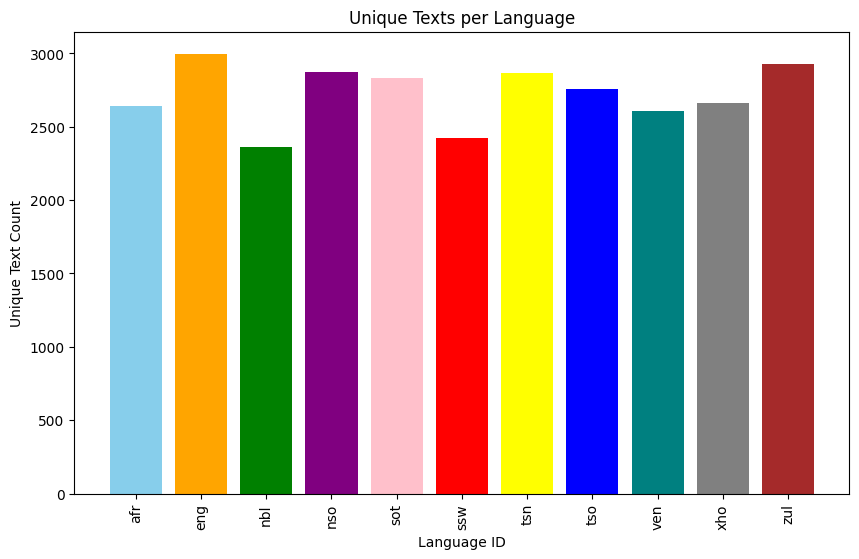

In [64]:
 
unique_text_counts = df_train_eda.groupby('lang_id')['text'].nunique()

# Sort the counts in descending order
unique_text_counts = unique_text_counts#.sort_values(ascending=False)

# Define a list of 11 colors for the bars
colors = ['skyblue', 'orange', 'green', 'purple', 'pink', 'red', 'yellow', 'blue', 'teal', 'gray', 'brown']

# Plot the histogram with different colors
plt.figure(figsize=(10, 6))
plt.bar(unique_text_counts.index, unique_text_counts.values, color=colors)

# Customize the plot
plt.xlabel('Language ID')
plt.ylabel('Unique Text Count')
plt.title('Unique Texts per Language')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed

# Display the plot
plt.show()

Below is a piechart showing percentages for each language

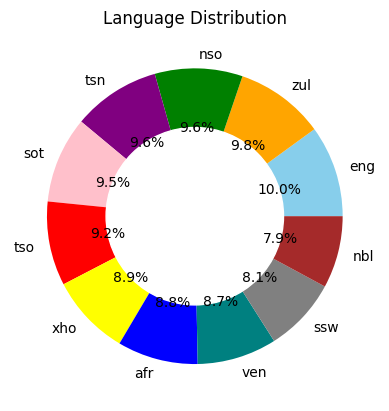

In [65]:
unique_text_counts = df_train_eda.groupby('lang_id')['text'].nunique()

# Sort the counts in descending order
unique_text_counts = unique_text_counts.sort_values(ascending=False)

# Set up the data for the pie chart
labels = unique_text_counts.index
sizes = unique_text_counts.values
colors = ['skyblue', 'orange', 'green', 'purple', 'pink', 'red', 'yellow', 'blue', 'teal', 'gray', 'brown']

# Create a pie chart with a hole
fig, ax = plt.subplots()

# Outer ring (full pie)
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')

# Inner ring (hole)
inner_circle = plt.Circle((0, 0), 0.6, color='white')  # Adjust the size of the hole as desired
ax.add_artist(inner_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.set_aspect('equal')

# Set a title
ax.set_title('Language Distribution')

# Display the chart
plt.show()



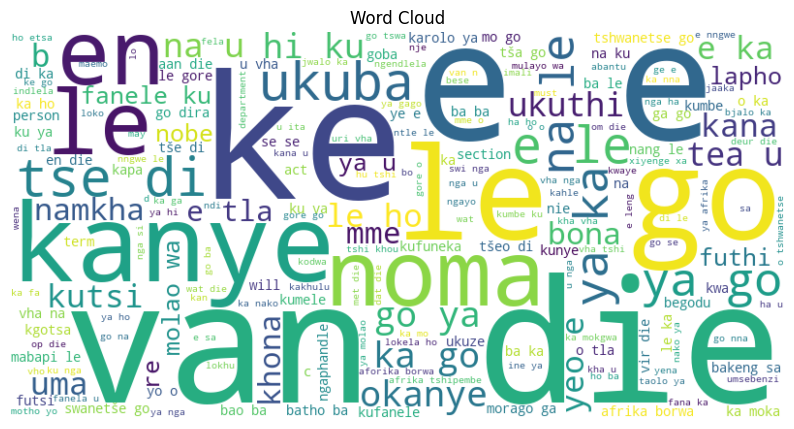

In [66]:
#wordcloud
comment_words = ''
stopwords = set(STOPWORDS)
text = ' '.join(df_train_eda['text'].astype(str))

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Set a title
plt.title('Word Cloud')

# Display the word cloud
plt.show()


# Data engineering

Remove the noise in the texts: Converthing the texts to a lowercase

In [67]:

def lowerCase(text):
    lowerCaseText = text.lower()
    return lowerCaseText

In [68]:
#make a copy of eda data
df_train_de = df_train.copy() 

In [69]:
df_train_de['text']  = df_train_de['text'].apply(lowerCase)

In [70]:
df_train_de.head(10)

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...
5,nso,dinyakišišo tše tša go dirwa gabedi ka ngwaga ...
6,tsn,kgetse nngwe le nngwe e e sa faposiwang mo tsh...
7,ven,mbadelo dze dza laelwa dzi do kwama mahatulele...
8,nso,maloko a dikhuduthamaga a ikarabela mongwe le ...
9,tsn,fa le dirisiwa lebone le tshwanetse go bontsha...


Below we remove the punctuations that are in the texts.

In [71]:
#function to remove punctuation
def remove_punc(text):
    #clean_text = re.sub(r'\b[\w\s]+\b', lambda match: re.sub(r'[^\w\s]', '', match.group()), text)
    clean_text = re.sub('[^A-Za-z\s]', '', text)
    
    #clean_text = re.s
    clean_text = re.sub('\\s+', ' ', clean_text)

    return clean_text
    

In [72]:
df_train_de['text'] = df_train_de['text'].apply(remove_punc)

In [73]:
#remove stopwords
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /Users/thebe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [74]:
df_train_de.head(10)

,lang_id,text
0,xho,umgaqosiseko wenza amalungiselelo kumaziko axh...
1,xho,idha iya kuba nobulumko bokubeka umsebenzi nap...
2,eng,the province of kwazulunatal department of tra...
3,nso,o netefata gore o ba file dilo ka moka te le d...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...
5,nso,dinyakiio te ta go dirwa gabedi ka ngwaga di t...
6,tsn,kgetse nngwe le nngwe e e sa faposiwang mo tsh...
7,ven,mbadelo dze dza laelwa dzi do kwama mahatulele...
8,nso,maloko a dikhuduthamaga a ikarabela mongwe le ...
9,tsn,fa le dirisiwa lebone le tshwanetse go bontsha...


In [75]:
#Tokenisation instentiation
word_token = TreebankWordTokenizer()


In [76]:
#pip install nlppreprocess


In [77]:
import nlppreprocess


In [78]:
import nltk
nltk.download('stopwords')
from nlppreprocess import NLP
nlp = NLP()
nlp.process('couldnt')

[nltk_data] Downloading package stopwords to /Users/thebe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'could not'

The function below removes the stop words like 'is','the'...etc

In [79]:
#remove stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(x):
    
    stopwords = NLP(replace_words=True, remove_stopwords=True, 
                            remove_numbers=True, remove_punctuations=False) 
    x = stopwords.process(x)
    return x
    
df_train_de['Text_nonstop'] = df_train_de['text'].apply(lambda x: remove_stopwords(x))

In [80]:
df_train_de.head(10)

,lang_id,text,Text_nonstop
0,xho,umgaqosiseko wenza amalungiselelo kumaziko axh...,umgaqosiseko wenza amalungiselelo kumaziko axh...
1,xho,idha iya kuba nobulumko bokubeka umsebenzi nap...,idha iya kuba nobulumko bokubeka umsebenzi nap...
2,eng,the province of kwazulunatal department of tra...,province kwazulunatal department transport inv...
3,nso,o netefata gore o ba file dilo ka moka te le d...,o netefata gore o ba file dilo ka moka te le d...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,khomishini ya ndinganyiso ya mbeu yo ewa maana...
5,nso,dinyakiio te ta go dirwa gabedi ka ngwaga di t...,dinyakiio te ta go dirwa gabedi ka ngwaga di t...
6,tsn,kgetse nngwe le nngwe e e sa faposiwang mo tsh...,kgetse nngwe le nngwe e e sa faposiwang mo tsh...
7,ven,mbadelo dze dza laelwa dzi do kwama mahatulele...,mbadelo dze dza laelwa dzi kwama mahatulele ap...
8,nso,maloko a dikhuduthamaga a ikarabela mongwe le ...,maloko dikhuduthamaga ikarabela mongwe le mong...
9,tsn,fa le dirisiwa lebone le tshwanetse go bontsha...,fa le dirisiwa lebone le tshwanetse go bontsha...


Tokenization

In [81]:
df_train_de['text_tokenized'] = df_train_de['Text_nonstop'].apply(word_token.tokenize)
df_train_de.head(10)

,lang_id,text,Text_nonstop,text_tokenized
0,xho,umgaqosiseko wenza amalungiselelo kumaziko axh...,umgaqosiseko wenza amalungiselelo kumaziko axh...,"[umgaqosiseko, wenza, amalungiselelo, kumaziko..."
1,xho,idha iya kuba nobulumko bokubeka umsebenzi nap...,idha iya kuba nobulumko bokubeka umsebenzi nap...,"[idha, iya, kuba, nobulumko, bokubeka, umseben..."
2,eng,the province of kwazulunatal department of tra...,province kwazulunatal department transport inv...,"[province, kwazulunatal, department, transport..."
3,nso,o netefata gore o ba file dilo ka moka te le d...,o netefata gore o ba file dilo ka moka te le d...,"[o, netefata, gore, o, ba, file, dilo, ka, mok..."
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,khomishini ya ndinganyiso ya mbeu yo ewa maana...,"[khomishini, ya, ndinganyiso, ya, mbeu, yo, ew..."
5,nso,dinyakiio te ta go dirwa gabedi ka ngwaga di t...,dinyakiio te ta go dirwa gabedi ka ngwaga di t...,"[dinyakiio, te, ta, go, dirwa, gabedi, ka, ngw..."
6,tsn,kgetse nngwe le nngwe e e sa faposiwang mo tsh...,kgetse nngwe le nngwe e e sa faposiwang mo tsh...,"[kgetse, nngwe, le, nngwe, e, e, sa, faposiwan..."
7,ven,mbadelo dze dza laelwa dzi do kwama mahatulele...,mbadelo dze dza laelwa dzi kwama mahatulele ap...,"[mbadelo, dze, dza, laelwa, dzi, kwama, mahatu..."
8,nso,maloko a dikhuduthamaga a ikarabela mongwe le ...,maloko dikhuduthamaga ikarabela mongwe le mong...,"[maloko, dikhuduthamaga, ikarabela, mongwe, le..."
9,tsn,fa le dirisiwa lebone le tshwanetse go bontsha...,fa le dirisiwa lebone le tshwanetse go bontsha...,"[fa, le, dirisiwa, lebone, le, tshwanetse, go,..."


In [82]:
df_test.head(10)

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.
5,6,"Ke feela dilense tše hlakilego, tša pono e tee..."
6,7,<fn>(762010101403 AM) 1495 Final Gems Birthing...
7,8,Ntjhafatso ya konteraka ya mosebetsi: Etsa bon...
8,9,u-GEMS uhlinzeka ngezinzuzo zemithi yezifo ezi...
9,10,"So, on occasion, are statistics misused."


The code below cleans the test dataset.The same steps that were followed to clean the train dataset are done here.

In [83]:
#processing the test data
df_test_copy = df_test.copy()
#cleaning the data?
df_test_copy['text'] = df_test_copy['text'].apply(lowerCase)
df_test_copy['text'] = df_test_copy['text'].apply(remove_punc)

df_test_copy['Text_nonstop'] = df_test_copy['text'].apply(lambda x: remove_stopwords(x))
df_test_copy['text_tokenized'] = df_test_copy['Text_nonstop'].apply(word_token.tokenize)


df_test_copy.head(10)

,index,text,Text_nonstop,text_tokenized
0,1,mmasepala fa maemo a a kgethegileng a letlelel...,mmasepala fa maemo kgethegileng letlelela kgat...,"[mmasepala, fa, maemo, kgethegileng, letlelela..."
1,2,uzakwaziswa ngokufaneleko nakungafuneka eminye...,uzakwaziswa ngokufaneleko nakungafuneka eminye...,"[uzakwaziswa, ngokufaneleko, nakungafuneka, em..."
2,3,tshivhumbeo tshi fana na ngano dza vhathu,tshivhumbeo tshi fana na ngano dza vhathu,"[tshivhumbeo, tshi, fana, na, ngano, dza, vhathu]"
3,4,kube inja nelikati betingevakala kutsi titsini...,kube inja nelikati betingevakala kutsi titsini...,"[kube, inja, nelikati, betingevakala, kutsi, t..."
4,5,winste op buitelandse valuta,winste op buitelandse valuta,"[winste, op, buitelandse, valuta]"
5,6,ke feela dilense te hlakilego ta pono e tee go...,ke feela dilense te hlakilego ta pono e tee go...,"[ke, feela, dilense, te, hlakilego, ta, pono, ..."
6,7,fn am final gems birthing optionszulutxtfn,fn am final gems birthing optionszulutxtfn,"[fn, am, final, gems, birthing, optionszulutxtfn]"
7,8,ntjhafatso ya konteraka ya mosebetsi etsa bonn...,ntjhafatso ya konteraka ya mosebetsi etsa bonn...,"[ntjhafatso, ya, konteraka, ya, mosebetsi, ets..."
8,9,ugems uhlinzeka ngezinzuzo zemithi yezifo ezin...,ugems uhlinzeka ngezinzuzo zemithi yezifo ezin...,"[ugems, uhlinzeka, ngezinzuzo, zemithi, yezifo..."
9,10,so on occasion are statistics misused,occasion are statistics misused,"[occasion, are, statistics, misused]"


In [84]:
#split the data into features and labels
X = df_train_de['Text_nonstop']
y = df_train_de['lang_id']
X.head(3)

0    umgaqosiseko wenza amalungiselelo kumaziko axh...
1    idha iya kuba nobulumko bokubeka umsebenzi nap...
2    province kwazulunatal department transport inv...
Name: Text_nonstop, dtype: object

Vectorization function

In [85]:


X_1 = [str(element) for element in X]
vectorizer = TfidfVectorizer(stop_words = 'english', max_df=0.9, ngram_range=(2, 8), analyzer= 'char').fit(X_1)
X_1 = vectorizer.transform(X_1)
#X_1.shape

  

Spliting the data into train and test datasets

In [86]:
#split the data 
X_train,X_test,y_train,y_test = train_test_split(X_1,y,test_size=.2,stratify=y,random_state=42)

In [87]:
y_train.head(3)

22148    tso
3034     tso
13406    eng
Name: lang_id, dtype: object

In [88]:
#build the logistic model
logreg = LogisticRegression(multi_class= 'ovr')
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       600
         eng       0.99      1.00      1.00       600
         nbl       1.00      1.00      1.00       600
         nso       1.00      1.00      1.00       600
         sot       1.00      1.00      1.00       600
         ssw       1.00      1.00      1.00       600
         tsn       1.00      1.00      1.00       600
         tso       1.00      1.00      1.00       600
         ven       1.00      1.00      1.00       600
         xho       1.00      0.99      1.00       600
         zul       1.00      0.99      1.00       600

    accuracy                           1.00      6600
   macro avg       1.00      1.00      1.00      6600
weighted avg       1.00      1.00      1.00      6600



In [89]:
#logistic regression with gridsearch to tune parameters
from sklearn.model_selection import GridSearchCV
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10.0],
    'solver': ['liblinear', 'saga'],
}

#Perform grid search with 5-fold cross-validation
#grid_logreg = GridSearchCV(logreg, param_grid, cv=5)
#grid_logreg.fit(X_train,y_train)
#y_pred_grid_log = grid_logreg.predict(X_test)
#print(classification_report(y_test,y_pred_grid_log))


In [90]:
#Building SVM model
#from sklearn.svm import SVC
#svc = SVC()
#svc.fit(X_train,y_train)
#y_predSVC = svc.predict(X_test)
#print(classification_report(y_test,y_predSVC))


#Building SVM model with gridsearch for hyperparameter tuning
#svc = SVC()

# Define the parameter grid to search
'param_grid = {
    'C': [0.1, 1.0, 10.0],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
}
#grid_svc = GridSearchCV(svc, param_grid, cv=5)
grid_svc.fit(X_train,y_train)
y_pred_grid_svc = svc.predict(X_test)
print(classification_report(y_test,y_pred_grid_svc))#

In [91]:
#y_predSVC.shape

### Building multinomial


In [92]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold

In [93]:
#model
model1 = MultinomialNB(alpha=1.0,class_prior=None,fit_prior=True)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True,
                                   random_state=42)
alpha = list(np.linspace(0.1,0.02,4))
param_grid = dict(alpha=alpha)
grid_search_M = GridSearchCV(estimator= model1,
                           param_grid=param_grid,
                           scoring='f1_weighted',
                           cv=stratified_kfold,
                           error_score=0,
                           n_jobs=-1)

In [94]:
grid_search_M.fit(X_train,y_train)
y_pred_M = grid_search_M.predict(X_test)
print(classification_report(y_test,y_pred_M))

              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       600
         eng       1.00      1.00      1.00       600
         nbl       1.00      1.00      1.00       600
         nso       1.00      1.00      1.00       600
         sot       1.00      1.00      1.00       600
         ssw       1.00      1.00      1.00       600
         tsn       1.00      1.00      1.00       600
         tso       1.00      1.00      1.00       600
         ven       1.00      1.00      1.00       600
         xho       1.00      1.00      1.00       600
         zul       1.00      1.00      1.00       600

    accuracy                           1.00      6600
   macro avg       1.00      1.00      1.00      6600
weighted avg       1.00      1.00      1.00      6600



In [95]:
y_test.shape

(6600,)

In [96]:
#Prediction from logistic regression
y_pred_t = logreg.predict(X_t)


In [97]:
#y_pred_grid_log = grid_logreg.predict(X_t)

In [98]:
#y_pred_svc = svc.predict(X_t)

In [99]:
#Predictions from multinomialNB
y_pred_MNB = grid_search_M.predict(X_t)

# Submission

In [100]:
#submission
Submission = pd.DataFrame()
Submission['index'] = df_test_copy['index']
Submission['lang_id'] = y_pred_MNB

Submission.to_csv("Submission.csv",index=False)
Submission

,index,lang_id
0,1,tsn
1,2,nbl
2,3,ven
3,4,ssw
4,5,afr
...,...,...
5677,5678,eng
5678,5679,nso
5679,5680,sot
5680,5681,sot
